In [118]:
%matplotlib inline
%pdb on
%run _547

Automatic pdb calling has been turned ON


# System model
Consider the simple pendulum model (see [1])
$$m\ddot{a} = -\frac{mg}{l} \sin(a) + \tau$$
where $a$ is pendulum angle, $l$ is rod length, $m$ is pendulum mass, $g$ is force due to gravity, and $\tau$ is an input torque arising from a motor attached to the rod at its pivot point.

If we measure or observe the pendulum angle (e.g. with an encoder on the pivot motor), then the ODE control system model is
$$\dot{x} = f(x,u),\ y = h(x)$$
where $x = (a,\dot{a})\in\mathbb{R}^2$, $u = \tau\in\mathbb{R}$, $f : \mathbb{R}^2 \times \mathbb{R} \rightarrow \mathbb{R}^2$ is defined by 
$$f((a,\dot{a}),u) = (\dot{a},\ddot{a}) = (\dot{a}, -\frac{g}{l} \sin(a) + \frac{1}{m}u),$$ 
and $h : \mathbb{R}^2 \rightarrow \mathbb{R}$ is defined by 
$$h(a,\dot{a}) = a.$$

    [1]: https://en.wikipedia.org/wiki/Pendulum_(mathematics)

# Simulation
To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [119]:
import numpy as np

g,l,m = 9.81,.5,1. # m/sec^2, m, kg

def f(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a) + (1/m)*u])

def h(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return a # output only the angle

Then we define the simulation algorithm:

In [120]:
def sim(f,t,x,u=lambda t:0.,dt=1e-4):
    j,t_,x_ = 0,[0],[x]
    while j*dt < t:
        t_.append((j+1)*dt)
        x_.append(x_[-1] + dt*f(j*dt,x_[-1],u(j*dt)))
        j += 1
    return np.array(t_),np.array(x_)

Note that $x_0 = (0,0)$ (i.e. zero angle and zero velocity) is an equilibrium:

In [121]:
x0 = [0,0]
print 'f(x0) =',f(0.,x0,0)

f(x0) = [ 0.  0.]


Now we can simulate and plot the result; recall that, for small angles, the period of the pendulum swing is (approximately) $2\pi\sqrt{l/g}$:

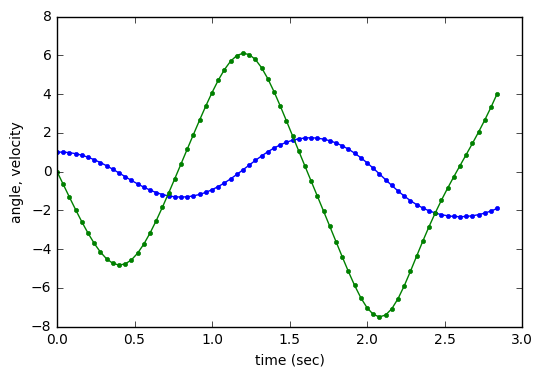

In [142]:
%matplotlib inline

import pylab as plt

t1 = 2*(2*np.pi*np.sqrt(l/g)) # approximately 2 periods
x1 = [1.,0.] # "interesting" initial condition
u1 = lambda t : 0 # zero input function
#equivalently:
def u1(t):
    return 0

t_,x_ = sim(f,t1,x1,u1,dt=4e-2)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]

plt.plot(t_,x_,'.-')
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

Recall from physics that the change in potential and kinetic energies are
$$PE = mgl\cos(a),\ KE =\frac{1}{2}m(l\dot{a})^2,$$
and that, in the absence of exogeneous input, any change in PE must be matched by an opposite change in KE, so PE - KE = 0.

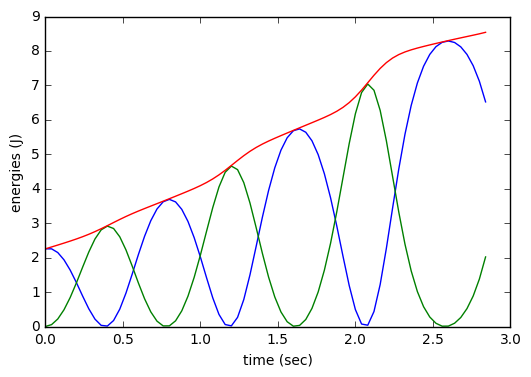

In [158]:
def E(x_):
    a,da = x_.T # angle (rad), velocity (rad/sec)
    PE,KE = m*(g*l)*(1-np.cos(a)),.5*m*(l*da)**2 # potential, kinetic energy
    return np.array([PE,KE,KE+PE])

plt.plot(t_,E(x_).T);
plt.xlabel('time (sec)');
plt.ylabel('energies (J)');

Looks good, but let's zoom in on that red curve (total change in energy):

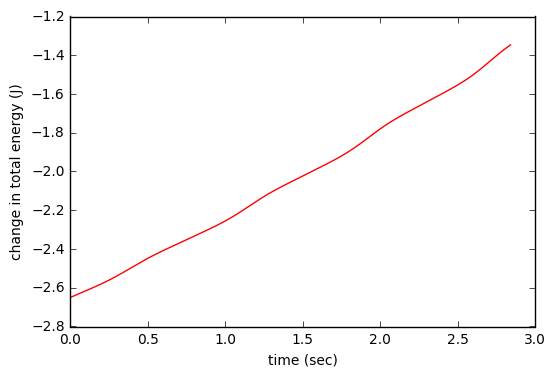

In [128]:
plt.plot(t_,E(x_)[2],'r');
plt.xlabel('time (sec)');
plt.ylabel('change in total energy (J)');

The energy in the simulation increases over time, even though energy is conserved in the real system's trajectories.  Thus, simulations do not always preserve properties of trajectories.

(-10.0, 10.0)

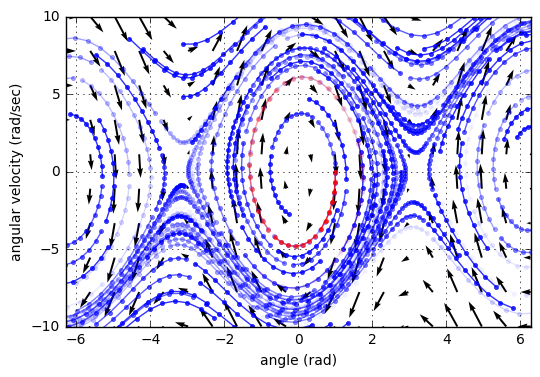

In [145]:
plt.figure(1); plt.grid('on')

alim = (-2*np.pi,2*np.pi)
dalim = (-10.,10.)

N = 50
T = 3*2*np.pi*np.sqrt(l/g)

np.random.seed(49)

A,dA = np.meshgrid(np.linspace(alim[0],alim[1],20),np.linspace(dalim[0],dalim[1],10))
A = A.flatten(); dA = dA.flatten(); ddA = 0.*dA
for k,(a,da) in enumerate(zip(A,dA)):
    ddA[k] = f(0.,[a,da],0.)[1]
plt.quiver(A,dA,dA,ddA)

for n in range(N):
    x1 = (np.random.rand()*np.diff(alim)+alim[0],
          np.random.rand()*np.diff(dalim)+dalim[0])
    _,trj = sim(f,T,x1,dt=4e-2)
    L = len(trj)/10
    for k in range(10):
        plt.plot(trj[k*L:(k+1)*L,0],trj[k*L:(k+1)*L,1],'b.-',alpha=(1.-((k+1.)/10.))**2)

        
L = len(x_)/10
for k in range(10):
    plt.plot(x_[k*L:(k+1)*L,0],x_[k*L:(k+1)*L,1],'r.-',alpha=(1.-((k+1.)/10.))**2)
    
plt.xlabel('angle (rad)'); plt.ylabel('angular velocity (rad/sec)')
plt.xlim(alim); plt.ylim(dalim)

In [136]:
f(0.,[np.pi,0],0.)

array([  0.00000000e+00,  -2.40275702e-15])

In [112]:
%run _anim

In [113]:
fig, ax = plt.subplots(figsize=(4,4)); ax.axis('equal'); ax.grid('on');

line, = ax.plot([], [], 'r.-', lw=4, ms=20);

# initialization -- called once
def init():
    line.set_data([], [])
    ax.set_xlim(( -1., 1.))
    ax.set_ylim(( -1., 1.))
    return (line,)

# animation -- called iteratively
def animate(t):
    j = (t_ >= t).nonzero()[0][0]
    th = x_[j,0]
    x = np.array([0.,l*np.sin(th)])
    y = np.array([0.,-l*np.cos(th)])
    line.set_data(x, y)
    return (line,)

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                        frames=np.arange(0.,t_[-1],.1), interval=1, blit=True)

# Linearization 

If we're given the derivative of the vector field function with respect to state, then we can approximate the linearization along a simulation trajectory.  Let's start with $D_x f$, the (Jacobian) derivative of the vector field $f$ with respect to the state $x = (a,\dot{a})$:
$$D_x f(x,u) = \left[ \begin{array}{cc} 0 & 1 \\ -\frac{g}{l}\cos(a) & 0 \end{array} \right]$$

In [146]:
def Dxf(x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([[0.,1.],[-(g/l)*np.cos(a),0.]])

Let's verify this is the derivative using finite-central-differences; we'll write a function that applies to general $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
$$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$

In [147]:
def D(g,y,d=1e-4):
    e = np.identity(len(y))
    Dyg = []
    for j in range(len(y)):
        Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
    return np.array(Dyg).T

Then we'll check that we get (approximately) the same result with the two methods (repeatedly press "Ctrl + Enter" to check at new random state):

In [155]:
x = np.random.randn(2)
print Dxf(x)
print D(lambda x : f(0.,x,0.), x, d=1e-6)

[[  0.           1.        ]
 [-19.08555204   0.        ]]
[[  0.           1.        ]
 [-19.08555204   0.        ]]


Note that finite-central-differences is sensitive to the "displacement" parameter:

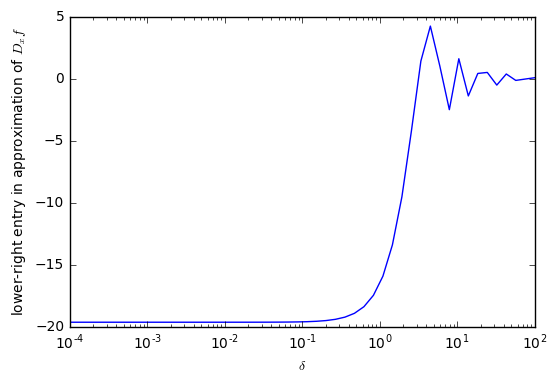

In [156]:
d = np.logspace(-4,2)
Dd = np.asarray([D(lambda x : f(0.,x,0.), x0, d=dd) for dd in d])
Dd.shape = (len(d),4)
plt.plot(d,Dd[:,2])
plt.xscale('log')
plt.xlabel('$\\delta$')
plt.ylabel('lower-left entry in approximation of $D_x f$')